# Neural Machine Translation

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext
# ! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt

# # Thanks to YSDA NLP course team for the data
# # (who thanks tilda and deephack teams for the data in their turn)

### Copy code from gdrive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !ls '/content/drive/My Drive/hw3'
# !cp '/content/drive/My Drive/hw3/'* ./

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Russian embeddings

In [3]:
# !pip install navec

In [ ]:
from navec import Navec

In [4]:
# !wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar

In [ ]:
path = 'navec_news_v1_1B_250K_300d_100q.tar'

In [ ]:
navec = Navec.load(path)

## Main part
__Here comes the preprocessing.__


### Russian tokenizer

In [ ]:
# !pip install pymorphy2==0.8
# !pip install spacy==2.1.9

In [5]:
# !git clone -b v2.1 https://github.com/buriy/spacy-ru.git
# !cp -r spacy-ru/ru2 ru2

In [6]:
# ! python3 -m spacy download en

In [ ]:
spacy_en = spacy.load('en')

In [ ]:
spacy.util.set_data_path('./')
spacy_ru = spacy.load('./ru2')

In [ ]:
def tokenize_ru(text):
    """
    Tokenizes Russian text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_ru.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
SRC = Field(tokenize=tokenize_en,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize_ru,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)


dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

### Load custom embeddings

In [ ]:
from tqdm.notebook import tqdm

word2vec_vectors = []
for token, idx in tqdm(TRG.vocab.stoi.items()):
    if token in navec.vocab:
        word2vec_vectors.append(torch.FloatTensor(navec[token]))
    else:
        word2vec_vectors.append(torch.zeros(300))

In [ ]:
TRG.vocab.set_vectors(TRG.vocab.stoi, word2vec_vectors, 300)

And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['it', 'also', 'features', 'an', 'innovative', 'alphasphere', '.'], 'src': ['в', 'нем', 'также', 'есть', 'инновационная', 'кушетка', 'альфасфера', '.']}


## Model side


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
# For reloading
import modules
import imp
imp.reload(modules)

Encoder = modules.Encoder
Attention = modules.Attention
Decoder = modules.Decoder
Seq2Seq = modules.Seq2Seq

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
HID_DIM = 256
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
BIDIRECT = True

enc = Encoder(
    INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS,
    ENC_DROPOUT, is_bidirectional=BIDIRECT
    )

attention = Attention(
    HID_DIM, HID_DIM, is_bidirectional=BIDIRECT, temperature=1
    )

dec = Decoder(
    OUTPUT_DIM, ENC_EMB_DIM, HID_DIM, attention, 1, DEC_DROPOUT,
    is_bidirectional=BIDIRECT
    )

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
src = next(iter(train_iterator)).src
trg = next(iter(train_iterator)).trg

# output, hidden, cell = enc.forward(src)
hidden, enc_states = enc.forward(src)
# output.shape, hidden.shape, cell.shape

batch_size = trg.shape[1]
max_len = trg.shape[0]
trg_vocab_size = dec.output_size

# batch_size, max_len, trg_vocab_size

outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(device)
# enc_states, hidden, cell = enc(src)
# hidden, cell = enc(src)
input_ = trg[0, :]

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9270, 300)
    (rnn): LSTM(300, 256, bidirectional=True)
    (out): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6837, 300)
    (rnn): GRU(812, 256)
    (out): Linear(in_features=1068, out_features=6837, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=768, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=1, bias=False)
    )
  )
)

In [ ]:
model.decoder.embedding.weight.data.copy_(TRG.vocab.vectors)

tensor([[ 0.0369,  0.0933,  0.0202,  ..., -0.1182, -0.0398,  0.0157],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4682, -0.3813, -0.6898,  ...,  0.3057,  0.1363, -0.2339]],
       device='cuda:0')

In [ ]:
model.decoder.embedding.weight.sum()

tensor(-3780.8416, device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,433,845 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', factor=0.75, verbose=True, patience=2
    )

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

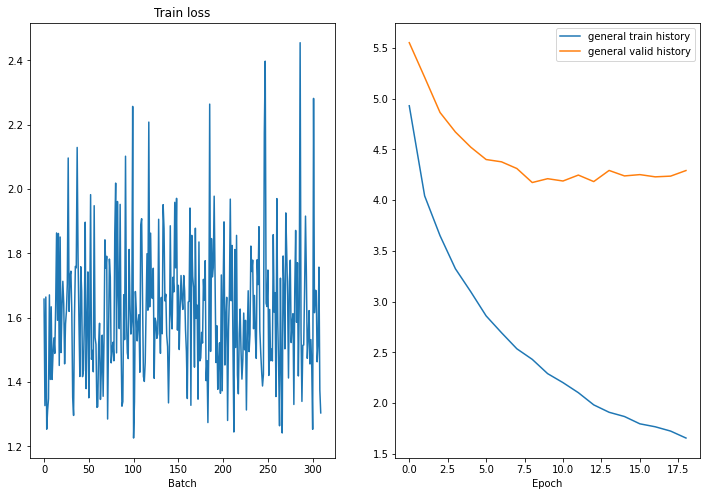

Epoch: 20 | Time: 1m 29s
	Train Loss: 1.616 | Train PPL:   5.035
	 Val. Loss: 4.302 |  Val. PPL:  73.864


In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(
        model, train_iterator, optimizer, criterion, CLIP,
        train_history, valid_history
        )
    valid_loss = evaluate(model, valid_iterator, criterion)
    scheduler.step(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there is a 24-hour front desk at the property .
Generated: you will find a 24-hour front desk at the property .
Original: each room offers air conditioning .
Generated: all rooms are air conditioning and air conditioning . air conditioning .


### Bleu

[original paper](https://www.aclweb.org/anthology/P02-1040.pdf)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

### Save best weights

In [ ]:
torch.save(model.state_dict(), 'best-final-model.pt')

In [ ]:
!cp best-final-model.pt '/content/drive/My Drive/hw3/!nlp_hw3_nmt_spacy_256hid_lstm_enc_rus_embeds.pt'

In [ ]:
model.load_state_dict(torch.load('best-final-model.pt'))

<All keys matched successfully>

In [7]:
import tqdm
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

26.56605012812398